# Term Frequency–Inverse Document Frequency (TFIDF)

All libraries

In [1]:
import pandas as pd
import numpy as np
import regex as re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from afinn import Afinn

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn import svm

from sklearn.linear_model import Lasso, LassoCV


from sklearn.pipeline import Pipeline

import time
import warnings
warnings.filterwarnings('ignore')


import matplotlib.pyplot as plt
%matplotlib inline

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Term-Frequency–Inverse-Document-Frequency-(TFIDF)" data-toc-modified-id="Term-Frequency–Inverse-Document-Frequency-(TFIDF)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Term Frequency–Inverse Document Frequency (TFIDF)</a></span></li><li><span><a href="#LogisticRegression:-Feature-Importance" data-toc-modified-id="LogisticRegression:-Feature-Importance-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>LogisticRegression: Feature Importance</a></span></li><li><span><a href="#MultinomialNB:-Feature-Importance" data-toc-modified-id="MultinomialNB:-Feature-Importance-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>MultinomialNB: Feature Importance</a></span></li></ul></div>

In this workbook, we examine three models: Logistic Regression, and (Multinomial) Naive Bayes. We particularly included the customized stop words containing name of the location and city, in order to being unweighted the location by occurrence and frequency in the model. We decided to adapt NB for for model because of the interpretability and overall performance, and then applied customized stop words for the final models. 

In [2]:
df = pd.read_csv('../data/balanced_df_tokenized_lemmatized.csv')
df['content'].fillna('', inplace=True)

In [3]:
X = df['content']
y = df['yes_disaster']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

In [5]:
knn = KNeighborsClassifier()
lr  = LogisticRegression(random_state=0, solver='lbfgs')
nb  = MultinomialNB()

In [6]:
from project4_function import model_scores

**Using the custom_stop_words_final**

In [7]:
# append the cuustomized words to the english stopwords
import pickle
custom_stop_words_final = pickle.load( open( "save.p", "rb" ) )
len(custom_stop_words_final)

2490

In [8]:
words_not_use = stopwords.words('english')
words_not_use.extend(custom_stop_words_final)

In [9]:
len(words_not_use) 

2669

In [10]:
tvec = TfidfVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = words_not_use) 

X_train_tvec_sw = tvec.fit_transform(X_train)
X_test_tvec_sw = tvec.transform(X_test)

In [11]:
models = [knn, lr, nb]

score_matrix = pd.DataFrame() 

for i in models:
    score_matrix = score_matrix.append(model_scores(i, X_train_tvec_sw, y_train, X_test_tvec_sw , y_test))
score_matrix

,model,accuracy score,recall score,cv train score,cv test score,train score,test score,train-test gap,model status,bias vs variance,fit time
0,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.753963,0.690922,0.770596,0.746768,0.842181,0.753963,0.088219,overfit,high variance,9.536743e-07
0,"LogisticRegression(C=1.0, class_weight=None, d...",0.795029,0.743516,0.793056,0.789287,0.852991,0.795029,0.057962,overfit,high variance,9.536743e-07
0,"MultinomialNB(alpha=1.0, class_prior=None, fit...",0.785663,0.775937,0.786933,0.776668,0.822844,0.785663,0.037181,overfit,high variance,0.000000e+00


# LogisticRegression: Feature Importance

1. For a binary classification problems this is basically the log of the estimated probability of a feature given the positive class. It means that higher values mean more important features towards your output variable.
2. The top features words such as hurricane, lava, storm, landslide in logistic regression will contribute most to the prediction variables. Having relevant features word can increase the accuracy of the models and reducing overfitting. 

In [12]:
lr = LogisticRegression()

my_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.5, 1.0, 25],
}
gs = GridSearchCV(lr, param_grid=my_params, cv=5)
gs = gs.fit(X_train_tvec_sw, y_train)
print(gs.best_score_)

0.7937785251020898


In [13]:
coef = gs.best_estimator_.coef_[0]

In [14]:
features_strength_df_sw = pd.DataFrame([tvec.get_feature_names(), coef ], 
                             index=['features','coefficient']).T.sort_values(by='coefficient',ascending=False)
features_strength_df_sw =features_strength_df_sw.dropna()

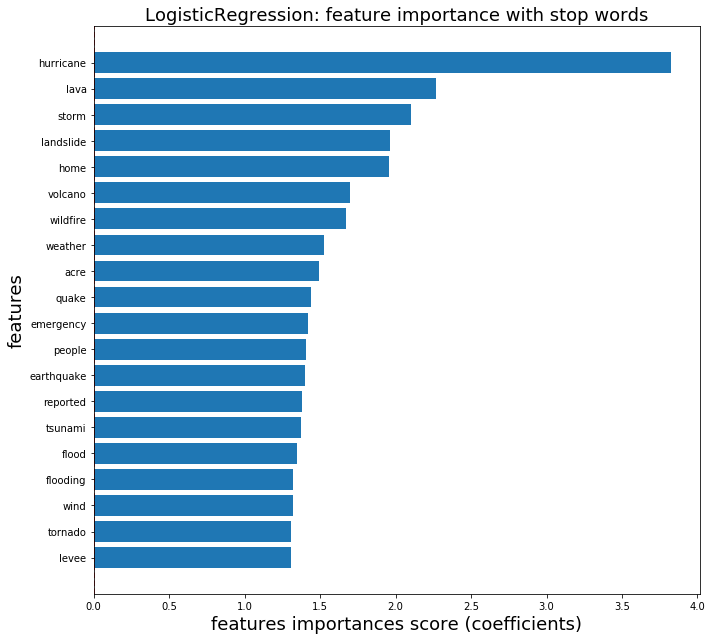

In [15]:
plt.figure(figsize=(10,9))
plt.title ('LogisticRegression: feature importance with stop words', fontsize=18)
plt.xlabel('features importances score (coefficients)', fontsize=18)
plt.ylabel('features', fontsize=18)
plt.axvline(x=0, color='r', linestyle='--')

plt.barh (y= features_strength_df_sw['features'][:20], width= features_strength_df_sw['coefficient'][:20])
plt.gca().invert_yaxis()
plt.tight_layout()

In [16]:
#Check if a certain location in the list; we should not have location show up in the feature list
'delhi' in list(features_strength_df_sw['features'])

False

# MultinomialNB: Feature Importance

1. Naive Bayes classifiers have worked quite well in many real-world situations for document classification. It requires a small amount of training data to estimate the necessary parameters.
2. While compare to the logistic regression, feature words in MultinomialNB will have a negative class, and we will sort the words by descending order. 

In [17]:
tvec_nb = TfidfVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = words_not_use) 

X_train_tvec_sw_nb = tvec_nb.fit_transform(X_train)
X_test_tvec_sw_nb = tvec_nb.transform(X_test)

In [18]:
nb = MultinomialNB()
gs_nb = nb.fit(X_train_tvec_sw_nb, y_train)

In [19]:
features_strength_df_sw_nb = pd.DataFrame([tvec_nb.get_feature_names(), gs_nb.coef_[0]], 
                             index=['features_nb','coefficient_nb']).T.sort_values(by='coefficient_nb',ascending=False)

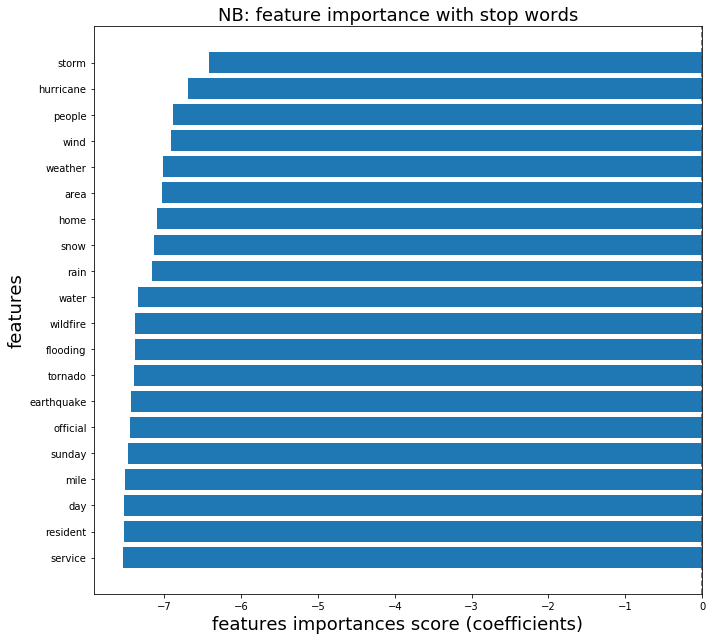

In [22]:
plt.figure(figsize=(10,9))
plt.title ('NB: feature importance with stop words', fontsize=18)
plt.xlabel('features importances score (coefficients)', fontsize=18)
plt.ylabel('features', fontsize=18)
plt.axvline(x=0, color='r', linestyle='--')

plt.barh (y= features_strength_df_sw_nb['features_nb'][:20], width= features_strength_df_sw_nb['coefficient_nb'][:20])
plt.gca().invert_yaxis()
plt.tight_layout()

In [24]:
features_strength_df_sw_top = list(features_strength_df_sw.features.head(1000))

features_strength_df_sw_nb_top = list(features_strength_df_sw_nb.features_nb.head(1000))

top_words_overlap = [word for word in features_strength_df_sw_top if word in features_strength_df_sw_nb_top]

In [26]:
len(top_words_overlap)/1000

0.466

In [28]:
top_words_overlap[:10]

['hurricane',
 'lava',
 'storm',
 'landslide',
 'home',
 'volcano',
 'wildfire',
 'weather',
 'acre',
 'quake']

Solving environment: \ 